<a href="https://colab.research.google.com/github/kondurprabhakarnuthanraju/TechSophy-Assignment/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 📦 Install required packages
!pip install pandas matplotlib seaborn scikit-learn gradio --quiet


In [2]:
# 📤 Upload your CSV file
from google.colab import files
import pandas as pd

uploaded = files.upload()
file_path = next(iter(uploaded))
df = pd.read_csv(file_path)
df.head()


Saving financial_anomaly_data.csv to financial_anomaly_data (1).csv


,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles


In [3]:
# 🧹 Clean and parse timestamp
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df.dropna(subset=["Timestamp", "Amount", "TransactionType"], inplace=True)
df.sort_values("Timestamp", inplace=True)
df["Month"] = df["Timestamp"].dt.to_period("M")
df["Type_Code"] = df["TransactionType"].astype("category").cat.codes
df.reset_index(drop=True, inplace=True)
df.head()


,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,Month,Type_Code
0,2023-01-01 08:00:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo,2023-01,0
1,2023-01-01 08:01:00,TXN1639,ACC10,15607.89,MerchantH,Purchase,London,2023-01,0
2,2023-01-01 08:02:00,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London,2023-01,2
3,2023-01-01 08:03:00,TXN1438,ACC6,87.87,MerchantE,Purchase,London,2023-01,0
4,2023-01-01 08:04:00,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles,2023-01,0


In [4]:
# 🔍 Detect outliers using Z-score
mean = df["Amount"].mean()
std = df["Amount"].std()
df["Z_score"] = (df["Amount"] - mean) / std
df["Anomaly"] = df["Z_score"].abs() > 3.0

print("✅ Anomalies Detected:", df["Anomaly"].sum())
df[df["Anomaly"]].head()


✅ Anomalies Detected: 7


,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,Month,Type_Code,Z_score,Anomaly
1899,2023-01-02 15:39:00,TXN1359,ACC11,151020.55,MerchantB,Transfer,Tokyo,2023-01,1,3.442860,True
1900,2023-01-02 15:40:00,TXN190,ACC5,873004.79,MerchantI,Withdrawal,Los Angeles,2023-01,2,28.082826,True
14295,2023-03-01 06:15:00,TXN1049,ACC14,978942.26,MerchantJ,Transfer,New York,2023-03,1,31.698273,True
14968,2023-03-01 17:28:00,TXN827,ACC12,712076.97,MerchantA,Withdrawal,Tokyo,2023-03,2,22.590662,True
14973,2023-03-01 17:33:00,TXN1690,ACC8,489492.30,MerchantF,Purchase,Tokyo,2023-03,0,14.994265,True


In [5]:
# 🧠 KMeans Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = df[["Amount", "Type_Code"]]
scaled = StandardScaler().fit_transform(features)

kmeans = KMeans(n_clusters=5, random_state=42)
df["Cluster"] = kmeans.fit_predict(scaled)

df[["Amount", "TransactionType", "Cluster"]].head()


,Amount,TransactionType,Cluster
0,95071.92,Purchase,3
1,15607.89,Purchase,0
2,65092.34,Withdrawal,1
3,87.87,Purchase,0
4,716.56,Purchase,0


/tmp/ipython-input-6-1978267874.py:12: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


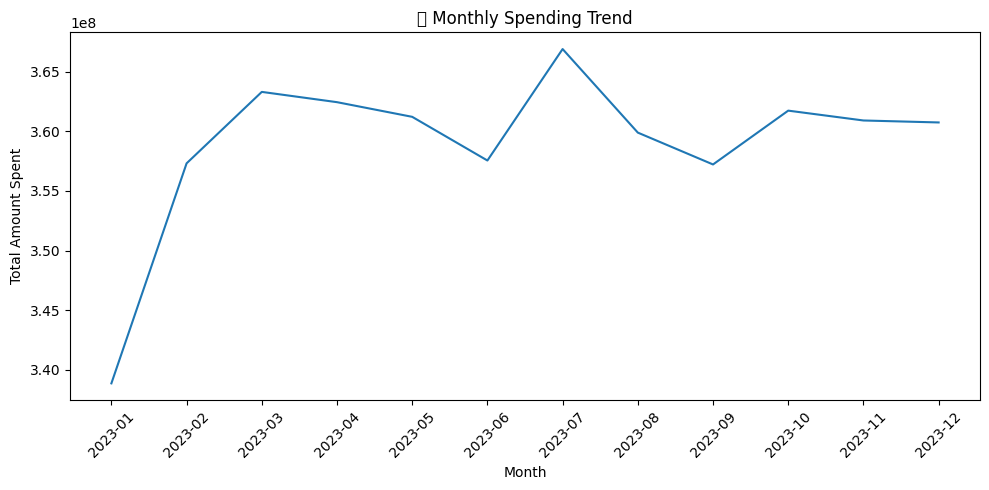

/tmp/ipython-input-6-1978267874.py:19: UserWarning: Glyph 128194 (\N{OPEN FILE FOLDER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128194 (\N{OPEN FILE FOLDER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


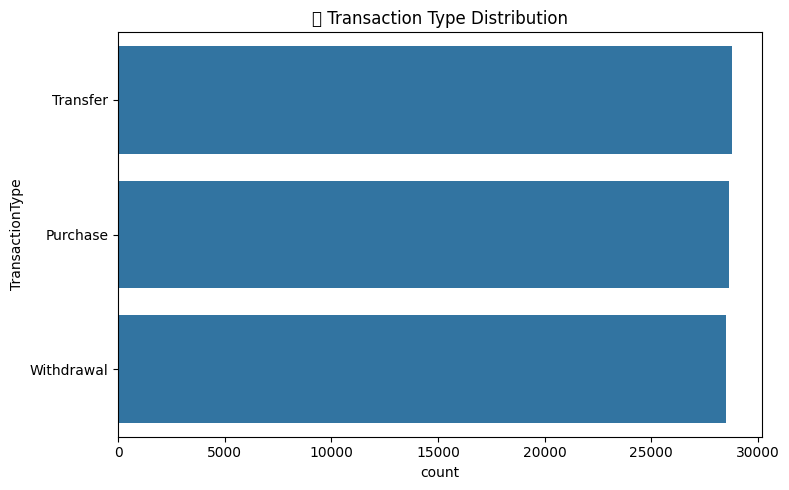

In [6]:
# 📈 Monthly Spending Trend
import matplotlib.pyplot as plt
import seaborn as sns

monthly = df.groupby("Month")["Amount"].sum().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly["Month"].astype(str), y=monthly["Amount"])
plt.title("📉 Monthly Spending Trend")
plt.xlabel("Month")
plt.ylabel("Total Amount Spent")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 📊 Transaction Type Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, y="TransactionType", order=df["TransactionType"].value_counts().index)
plt.title("📂 Transaction Type Distribution")
plt.tight_layout()
plt.show()


In [7]:
# 💡 Generate Smart Insights
insights = []
total_spent = df["Amount"].sum()

withdrawals = df[df["TransactionType"].str.lower() == "withdrawal"]
if not withdrawals.empty:
    ratio = withdrawals["Amount"].sum() / total_spent
    if ratio > 0.4:
        insights.append("⚠️ High withdrawal volume. Consider limiting cash withdrawals.")

num_anomalies = df["Anomaly"].sum()
if num_anomalies > 0:
    insights.append(f"⚠️ {num_anomalies} unusual transactions flagged (Z-score > 3.0).")

if not insights:
    insights.append("✅ No unusual patterns detected. Financial behavior is stable.")

print("📌 Recommendations:")
for insight in insights:
    print("-", insight)


📌 Recommendations:
- ⚠️ 7 unusual transactions flagged (Z-score > 3.0).


In [8]:
# 📏 Clustering Evaluation: Silhouette Score
from sklearn.metrics import silhouette_score

score = silhouette_score(scaled, df["Cluster"])
print(f"✅ Silhouette Score: {score:.3f} (Higher is better, max = 1)")

# Show cluster distribution
print("\n🔢 Cluster Distribution:")
print(df["Cluster"].value_counts().sort_index())


✅ Silhouette Score: 0.495 (Higher is better, max = 1)

🔢 Cluster Distribution:
Cluster
0    16164
1    14451
2    14068
3    25035
4    16202
Name: count, dtype: int64


In [9]:
# ✅ FIXED: Interactive Transaction Checker (Gradio)
import gradio as gr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# ✅ Fit scaler and model again for safety
feature_cols = ["Amount", "Type_Code"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols])
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)

# ✅ Build safe interface function
def recommend(transaction_type, amount):
    try:
        type_code = df[df["TransactionType"] == transaction_type]["Type_Code"].mode()[0]
        z = (amount - df["Amount"].mean()) / df["Amount"].std()
        cluster_input = scaler.transform([[amount, type_code]])
        cluster = kmeans.predict(cluster_input)[0]

        alert = "✅ Normal transaction"
        if abs(z) > 3:
            alert = "⚠️ Unusual transaction detected!"

        return f"""
        🔢 Z-Score: {z:.2f}
        🔗 Cluster ID: {cluster}
        📣 Status: {alert}
        """

    except Exception as e:
        return f"❌ Error: {str(e)}"

# ✅ Launch the interface
gr.Interface(
    fn=recommend,
    inputs=[
        gr.Dropdown(choices=sorted(df["TransactionType"].unique()), label="Transaction Type"),
        gr.Number(label="Transaction Amount")
    ],
    outputs="text",
    title="💸 Personal Finance Transaction Checker",
    description="Check if a transaction is anomalous and view its cluster group."
).launch(share=True)  # Use share=True for public link


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7e184d3de0f2f1b18e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
